# TP1 : Practical work on mathematical morphology

In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  4 10:23:50 2018
Modified Oct 2020, Oct 2021, Oct 2023

@author: Said Ladjal,Isabelle Bloch
"""


#%% SECTION 1 -- inclusion of packages


import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import measure, filters, io as skio


import skimage.morphology as morpho 
from skimage.segmentation import watershed
from skimage.draw import line
import skimage.feature as skf
from scipy import ndimage as ndi


## 1 - Morphologie mathematique sur des images a niveaux de gris

In [3]:
#%% SECTION 2 -- Useful functions

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)


def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)


def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.diamond(taille)
    if forme == 'disk':
        return morpho.disk(taille)
    if forme == 'square':
        return morpho.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')

            

def couleurs_alea(im):
    """ 
    Donne des couleurs aleatoires a une image en niveau de gris.
    Cette fonction est utile lorsque le niveua de gris d'interprete comme un numero
      de region. Ou encore pour voir les leger degrades d'une teinte de gris.
      """
    sh=im.shape
    out=np.zeros((sh[0],sh[1],3),dtype=np.uint8)
    nbcoul=np.int32(im.max())
    tabcoul=np.random.randint(0,256,size=(nbcoul+1,3))
    tabcoul[0,:]=0
    for k in range(sh[0]):
        for l in range(sh[1]):
            out[k,l,:]=tabcoul[im[k,l]]
    return out

def gris_depuis_couleur(im):
    """ Transforme une image couleur en image a niveaux de gris"""
    return im[:,:,:3].sum(axis=2)/3
    

im_cellbin =  (512, 512)
im_cafe = (256, 256)
im_retina = (256, 256)
im_bat200 = (200, 200)
im_bulles= (253, 255)
im_cailloux = (300, 384)
im_cailloux2 = (378, 527)
im_laiton = (256, 256)
im_citrons =  (4128, 3096)


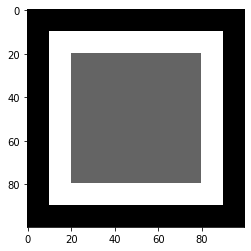

In [4]:

#%% SECTION 3 -- Examples of functions for this work

# Binary images 

im_cellbin=skio.imread('images/cellbin.bmp')
print("im_cellbin = ",im_cellbin.shape)

im_cafe=skio.imread('images/cafe.bmp')
print("im_cafe =", im_cafe.shape)

# Gray-scale images

im_retina=skio.imread('images/retina2.gif')
print("im_retina =", im_retina.shape)

im_bat200=skio.imread('images/bat200.png')
print("im_bat200 =", im_bat200.shape)


im_bulles=skio.imread('images/bulles.png')
print("im_bulles=", im_bulles.shape)

im_cailloux=gris_depuis_couleur(skio.imread('images/cailloux.png'))
print("im_cailloux =", im_cailloux.shape)

im_cailloux2=gris_depuis_couleur(skio.imread('images/cailloux2.png'))
print("im_cailloux2 =", im_cailloux2.shape)

im_laiton=skio.imread('images/laiton.png')
print("im_laiton =", im_laiton.shape)

im_citrons=gris_depuis_couleur((skio.imread('images/citrons.jpg')))
print("im_citrons = ", im_citrons.shape)

im_square=np.zeros((100,100))
im_square[10:20,10:90]=254
im_square[80:90,10:90]=254
im_square[10:90,80:90]=254
im_square[10:90,10:20]=254
im_square[20:80,20:80]=100

plt.imshow(im_square, cmap = "gray")

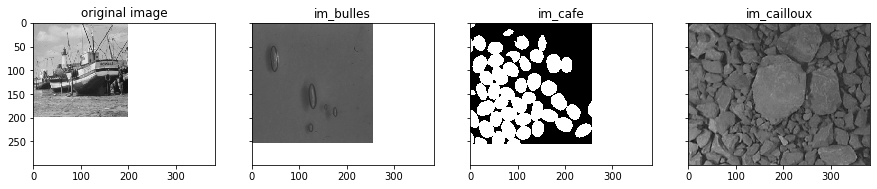

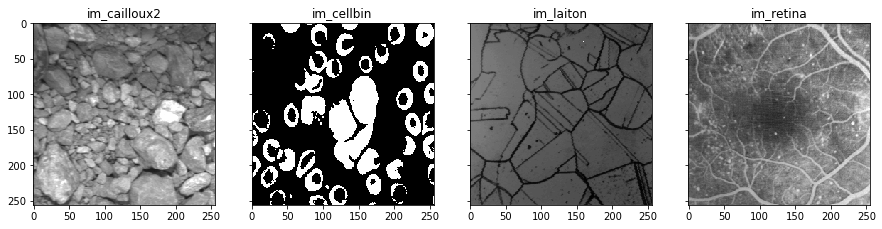

In [8]:
# Visualisation des images 

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im_bat200,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(im_bulles,cmap="gray",vmin=0, vmax=255)
axs[1].set_title('im_bulles')
axs[2].imshow(im_cafe,cmap="gray",vmin=0, vmax=255)
axs[2].set_title('im_cafe')
axs[3].imshow(im_cailloux,cmap="gray",vmin=0, vmax=255)
axs[3].set_title('im_cailloux')
plt.show()

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im_cailloux2,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('im_cailloux2')
axs[1].imshow(im_cellbin,cmap="gray",vmin=0, vmax=255)
axs[1].set_title('im_cellbin')
axs[2].imshow(im_laiton,cmap="gray",vmin=0, vmax=255)
axs[2].set_title('im_laiton')
axs[3].imshow(im_retina,cmap="gray",vmin=0, vmax=255)
axs[3].set_title('im_retina')

plt.show()

### Question 1&2

Text(0.5, 1.0, 'line : 8')

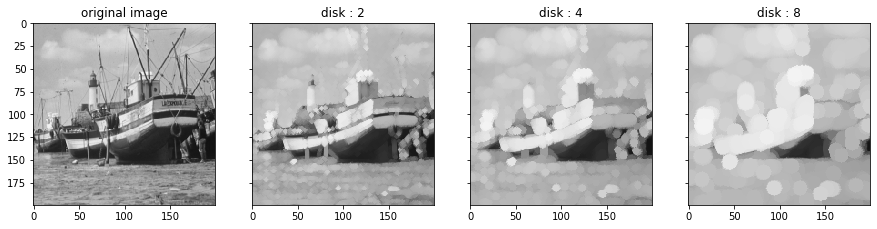

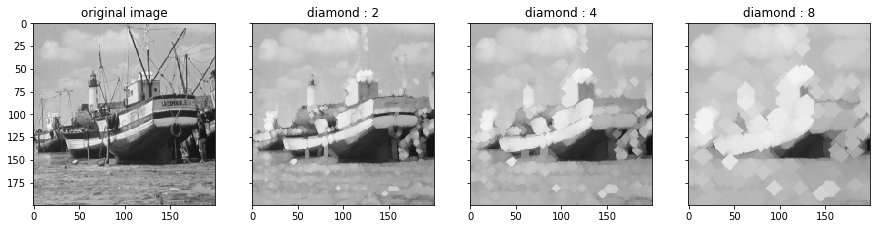

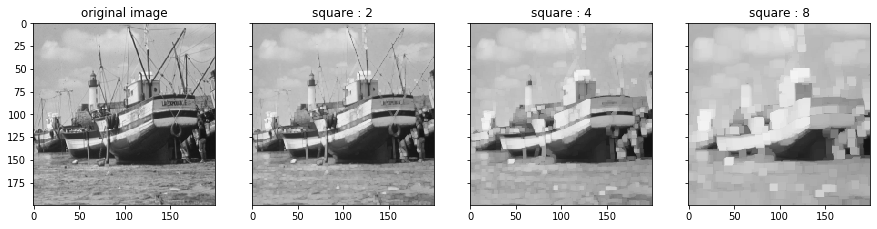

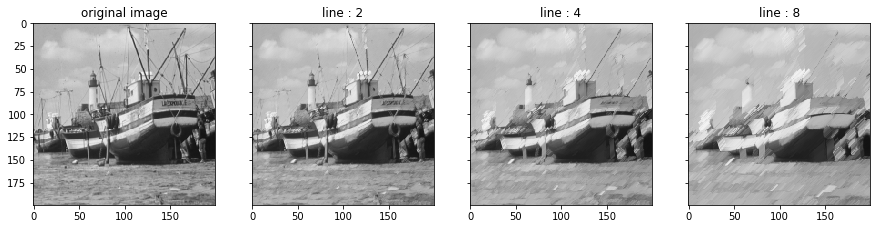

In [58]:
# IMAGE
im = im_bat200
#im = im_bulles
#im = im_cafe
#im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
#im = im_retina
#im = im_square
#im = im_citrons

#SHAPE
shapes_d=['diamond', 'square', 'disk', 'line']

#OPERATION
#op = morpho.erosion
op = morpho.dilation
#op = morpho.closing
#op = morpho.opening


shape_d = "disk"
axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(op(im,strel(shape_d,2)),cmap="gray",vmin=0, vmax=255)
axs[1].set_title(shape_d+' : 2')
axs[2].imshow(op(im,strel(shape_d,4)),cmap="gray",vmin=0, vmax=255)
axs[2].set_title(shape_d+' : 4')
axs[3].imshow(op(im,strel(shape_d,8)),cmap="gray",vmin=0, vmax=255)
axs[3].set_title(shape_d+' : 8')

#plt.savefig('images/dil_disque_laiton.pdf', bbox_inches='tight')


shape_d = "diamond"
axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(op(im,strel(shape_d,2)),cmap="gray",vmin=0, vmax=255)
axs[1].set_title(shape_d+' : 2')
axs[2].imshow(op(im,strel(shape_d,4)),cmap="gray",vmin=0, vmax=255)
axs[2].set_title(shape_d+' : 4')
axs[3].imshow(op(im,strel(shape_d,8)),cmap="gray",vmin=0, vmax=255)
axs[3].set_title(shape_d+' : 8')


shape_d = "square"
axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(op(im,strel(shape_d,2)),cmap="gray",vmin=0, vmax=255)
axs[1].set_title(shape_d+' : 2')
axs[2].imshow(op(im,strel(shape_d,4)),cmap="gray",vmin=0, vmax=255)
axs[2].set_title(shape_d+' : 4')
axs[3].imshow(op(im,strel(shape_d,8)),cmap="gray",vmin=0, vmax=255)
axs[3].set_title(shape_d+' : 8')

shape_d = "line"
axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(op(im,strel(shape_d,2)),cmap="gray",vmin=0, vmax=255)
axs[1].set_title(shape_d+' : 2')
axs[2].imshow(op(im,strel(shape_d,4)),cmap="gray",vmin=0, vmax=255)
axs[2].set_title(shape_d+' : 4')
axs[3].imshow(op(im,strel(shape_d,8)),cmap="gray",vmin=0, vmax=255)
axs[3].set_title(shape_d+' : 8')

#plt.savefig('images/op_line_eye.pdf', bbox_inches='tight')


##### Pour chaque opération, on pose une taille et on fait varier les formes

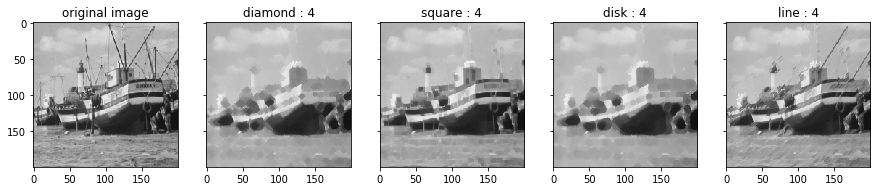

In [235]:
# IMAGE
im = im_bat200
#im = im_bulles
#im = im_cafe
#im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
#im = im_retina
#im = im_square
#im = im_citrons

#SHAPE
shapes_d=['diamond', 'square', 'disk', 'line']

#OPERATION
#op = morpho.erosion
#op = morpho.dilation
op = morpho.closing
#op = morpho.opening

size = 4

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 5, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

i = 1
for shape_d in shapes_d:
    axs[i].imshow(op(im,strel(shape_d,size)),cmap="gray",vmin=0, vmax=255)
    axs[i].set_title(shape_d+" : "+str(size))
    i+=1
#plt.savefig('images/close_shapes.pdf', bbox_inches='tight')



##### Pour chaque opération, on pose une forme et on fait varier les tailles

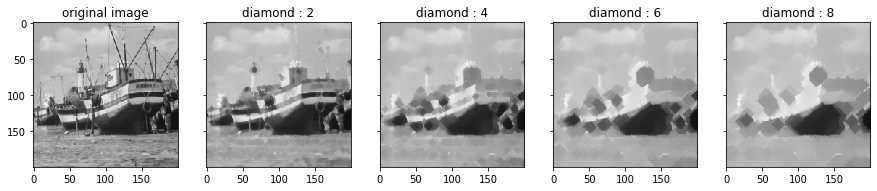

In [240]:
# IMAGE
im = im_bat200
#im = im_bulles
#im = im_cafe
#im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
#im = im_retina
#im = im_square
#im = im_citrons

#SHAPE
shape_d = 'diamond'
#shape_d = 'square'
#shape_d = 'disk'
#shape_d = 'line'



#OPERATION
#op = morpho.erosion
#op = morpho.dilation
op = morpho.closing
#op = morpho.opening

sizes = [2,4,6,8]

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 5, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

i = 1
for size in sizes:
    axs[i].imshow(op(im,strel(shape_d,size)),cmap="gray",vmin=0, vmax=255)
    axs[i].set_title(shape_d+" : "+str(size))
    i+=1
plt.savefig('images/clos_sizes.pdf', bbox_inches='tight')



##### Indempotence

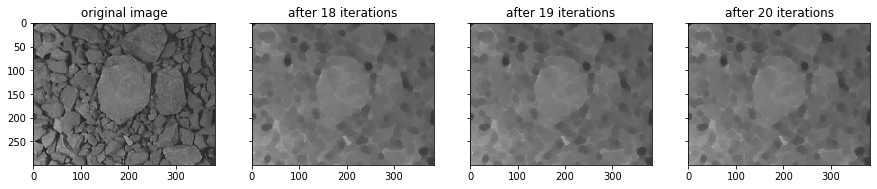

In [9]:
def repeat_op(im, op, n_iter, shape_d, size):
    l_im = []
    if n_iter < 4:
        print("not enough iterations")
        return im
    tmp_im = im.copy()
    for i in range(n_iter):
        tmp_im = op(tmp_im, strel(shape_d, size))
        l_im.append(tmp_im)
    return l_im

# IMAGE
#im = im_bat200
#im = im_bulles
#im = im_cafe
im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
#im = im_retina
#im = im_square
#im = im_citrons

#SHAPE
#shape_d = 'diamond'
#shape_d = 'square'
shape_d = 'disk'
#shape_d = 'line'



#OPERATION
#op = morpho.erosion
#op = morpho.dilation
op = morpho.closing
#op = morpho.opening

size = 6
n_iter = 20
l_im = repeat_op(im, op, n_iter, shape_d, size)[n_iter-3:]

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

for i in range(1, 4):
    axs[i].imshow(l_im[i-1],cmap="gray",vmin=0, vmax=255)
    axs[i].set_title("after "+str(n_iter-(3-i))+" iterations")
    i+=1
#plt.savefig('images/close_idempotence.pdf', bbox_inches='tight')



##### Associativité

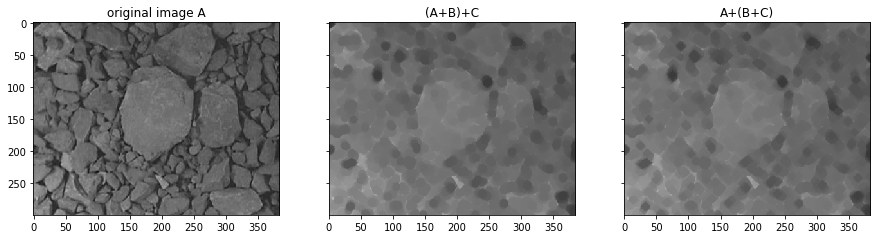

In [269]:
# IMAGE
#im = im_bat200
#im = im_bulles
#im = im_cafe
im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
#im = im_retina
#im = im_square
#im = im_citrons

#SHAPE
#shape_d = 'diamond'
#shape_d = 'square'
#shape_d = 'disk'
#shape_d = 'line'



#OPERATION
#op = morpho.erosion
#op = morpho.dilation
op = morpho.closing
#op = morpho.opening

el_str1 = strel('diamond', 4)
el_str2 = strel('disk', 6)

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 3, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image A')

axs[1].imshow(op(op(im, el_str1), el_str2),cmap="gray",vmin=0, vmax=255)
axs[1].set_title("(A+B)+C")

axs[2].imshow(op(op(im, el_str2), el_str1),cmap="gray",vmin=0, vmax=255)
axs[2].set_title("A+(B+C)")


#plt.savefig('images/close_assoc.pdf', bbox_inches='tight')



##### Extensivité / Anti-extensivité

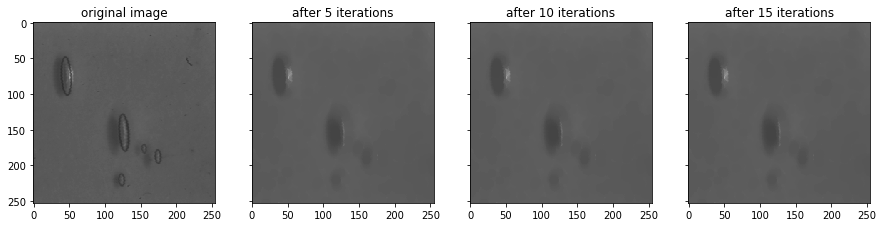

In [279]:
# IMAGE
#im = im_bat200
im = im_bulles
#im = im_cafe
#im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
#im = im_retina
#im = im_square
#im = im_citrons

#SHAPE
#shape_d = 'diamond'
#shape_d = 'square'
shape_d = 'disk'
#shape_d = 'line'



#OPERATION
#op = morpho.erosion
#op = morpho.dilation
op = morpho.closing
#op = morpho.opening

size = 6
n_iter = 20
l_im = repeat_op(im, op, n_iter, shape_d, size)

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

j = [5,10,15]
for i in range(1, 4):
    axs[i].imshow(l_im[j[i-1]],cmap="gray",vmin=0, vmax=255)
    axs[i].set_title("after "+str(j[i-1])+" iterations")
    i+=1
#plt.savefig('images/ero_anti_extensive.pdf', bbox_inches='tight')



### Question 4

#### Top-Hat Transform (THT)

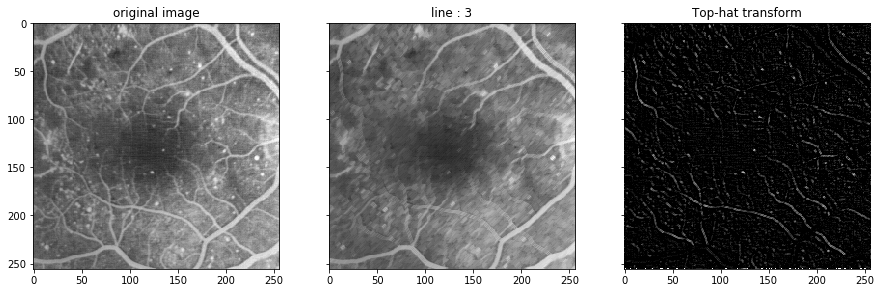

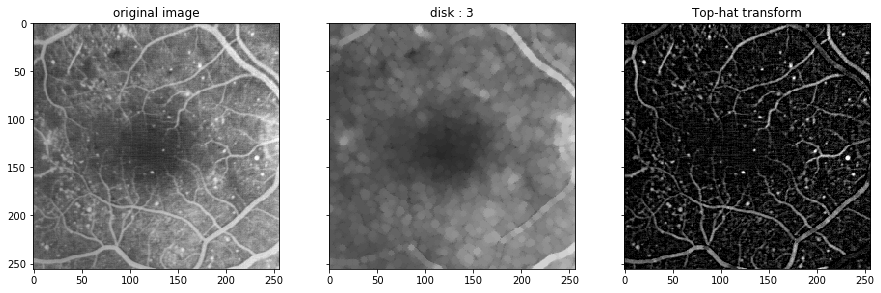

In [127]:
# IMAGE
#im = im_bat200
#im = im_bulles
#im = im_cafe
#im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
im = im_retina
#im = im_square
#im = im_citrons


#SHAPE
#diamond’, ’square’, ’disk’, ’line’,

#OPERATION
#op = morpho.erosion
#op = morpho.dilation
#op = morpho.closing
op = morpho.opening

shape_d = "line"
axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 3, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(op(im,strel(shape_d,3)),cmap="gray",vmin=0, vmax=255)
axs[1].set_title(shape_d+' : 3')
axs[2].imshow(im -op(im,strel(shape_d,3)),cmap="gray", vmin=0, vmax=110)
axs[2].set_title("Top-hat transform")

plt.savefig('images/tht_eye1.pdf', bbox_inches='tight')
plt.show()

#OPERATION
#op = morpho.erosion
#op = morpho.dilation
#op = morpho.closing
op = morpho.opening

shape_d = "disk"
axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 3, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(op(im,strel(shape_d,3)),cmap="gray",vmin=0, vmax=255)
axs[1].set_title(shape_d+' : 3')
axs[2].imshow(im -op(im,strel(shape_d,3)),cmap="gray", vmin=0, vmax=110)
axs[2].set_title("Top-hat transform")

#plt.savefig('images/tht_eye2.pdf', bbox_inches='tight')



#### Bottom-Hat Transform (BHT)

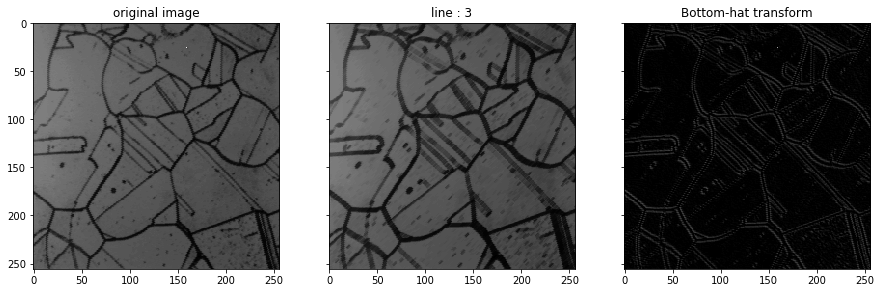

In [126]:
# IMAGE
#im = im_bat200
#im = im_bulles
#im = im_cafe
#im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
im = im_laiton
#im = im_retina
#im = im_square
#im = im_citrons


#SHAPE
#diamond’, ’square’, ’disk’, ’line’,

#OPERATION
op = morpho.erosion
#op = morpho.dilation
#op = morpho.closing
#op = morpho.opening

shape_d = "line"
axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1, 3, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(op(im,strel(shape_d,3)),cmap="gray",vmin=0, vmax=255)
axs[1].set_title(shape_d+' : 3')
axs[2].imshow(im -op(im,strel(shape_d,3)),cmap="gray", vmin=0, vmax=255)
axs[2].set_title("Bottom-hat transform")

#plt.savefig('images/bht_laiton.pdf', bbox_inches='tight')


### Question 5

6


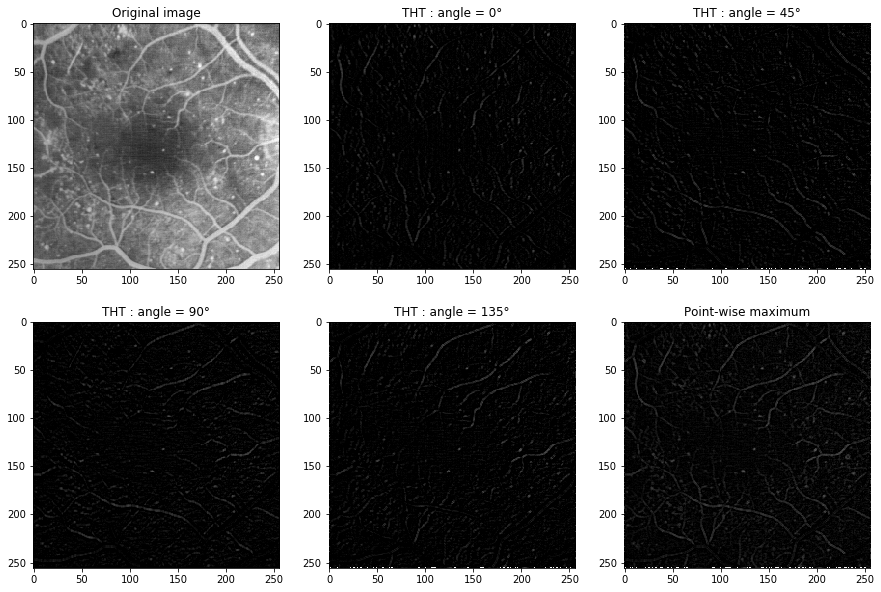

In [163]:
# IMAGE
#im = im_bat200
#im = im_bulles
#im = im_cafe
#im = im_cailloux
#im = im_cailloux2
#im = im_cellbin
#im = im_laiton
im = im_retina
#im = im_square
#im = im_citrons


#SHAPE
#diamond’, ’square’, ’disk’, ’line’,

#OPERATION
#op = morpho.erosion
#op = morpho.dilation
#op = morpho.closing
op = morpho.opening

shape_d = "line"

angles = [0, 45, 90, 135]
images = [im]+[im - op(im,strel(shape_d,3, angle)) for angle in angles]
images.append(np.maximum.reduce(images[1:]))

titles = ["Original image"] + ["THT : angle = "+str(angle)+"°" for angle in angles]+["Point-wise maximum"]
print(len(titles))

axs = (plt.figure(figsize=(15,20),constrained_layout=False)
           .subplots(2, 3, sharex=False, sharey=False))

for i in range(6):
    if i<3:
        axs[0][i].imshow(images[i],cmap="gray",vmin=0, vmax=255)
        axs[0][i].set_title(titles[i])
    else:
        axs[1][i-3].imshow(images[i],cmap="gray",vmin=0, vmax=255)
        axs[1][i-3].set_title(titles[i])


plt.subplots_adjust(bottom=0.5)

#plt.savefig('images/THT_pw_max.pdf', bbox_inches='tight')
plt.show()
    


## 2 - Alternate sequential filters

In [10]:
def sequential_f(im,se_shape, max_size):
    tmp_im=im.copy()
    l_im = []
    angle = 0
    for i in range(1, max_size+1):  
        if se_shape == "line":
            tmp_im=morpho.opening(tmp_im,strel(se_shape, i, angle))
            tmp_im=morpho.closing(tmp_im,strel(se_shape, i, angle))
            angle+=30
        else:
            tmp_im=morpho.opening(tmp_im,strel(se_shape, i))
            tmp_im=morpho.closing(tmp_im,strel(se_shape, i))

    return tmp_im


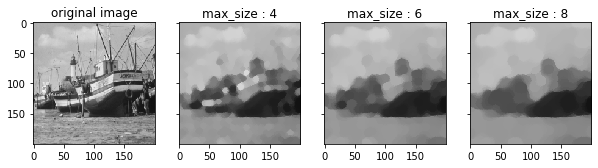

In [122]:
im= im_bat200
shape_d = "disk"
max_sizes = [4,6,8]
axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
i = 0
for max_size in max_sizes:
    i += 1
    im_seq = sequential_f(im,shape_d,max_size)
    axs[i].imshow(im_seq,cmap="gray",vmin=0, vmax=255)
    axs[i].set_title('max_size : '+ str(max_size))
#plt.savefig("images/asf_"+shape_d)


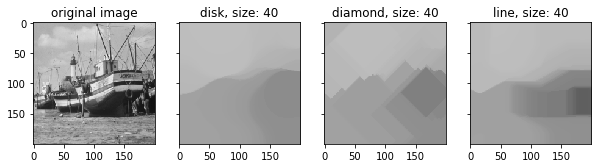

In [227]:
im= im_bat200
#shape_d = "line"
max_size = 40
axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
i = 0
for shape_d in ["disk", "diamond", "line"] :
    i += 1
    im_seq = sequential_f(im,shape_d,max_size)
    axs[i].imshow(im_seq,cmap="gray",vmin=0, vmax=255)
    axs[i].set_title(shape_d+', size: '+ str(max_size))
#plt.savefig("images/asf_large", bbox_inches='tight')


## 3 - Reconstruction

(256, 256)


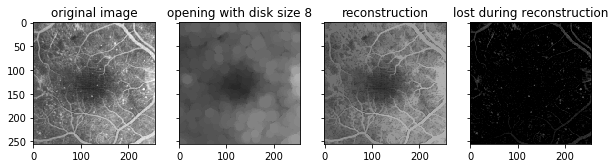

In [66]:
#reconstruction by dilation from opening
im=im_retina
print(im.shape)
shape_d = "disk"
#shape_d = "line"
size = 8
se4 = strel(shape_d,size,60)
open4 = morpho.opening(im,se4)
reco=morpho.reconstruction(open4,im)

axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(open4,cmap="gray",vmin=0, vmax=255)
axs[1].set_title("opening with "+shape_d+" size "+str(size))
axs[2].imshow(reco,cmap="gray",vmin=0, vmax=255)
axs[2].set_title("reconstruction")
axs[3].imshow(im-reco,cmap="gray",vmin=0, vmax=255)
axs[3].set_title("lost during reconstruction")
#plt.savefig("images/reco_by_dil",bbox_inches='tight' )
plt.show()


In [ ]:
## A METTRE DS LE LATEX
# Comment the results

(256, 256)


Text(0.5, 1.0, 'lost during reconstruction')

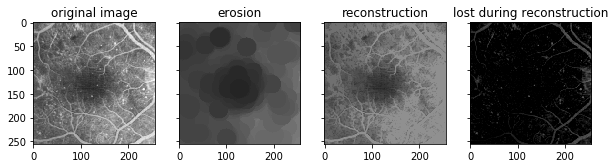

In [21]:
# Reconstruction from erosion
im=im_retina
print(im.shape)
shape_d = "disk"
#shape_d = "line"
size = 20
se4 = strel(shape_d,size)
eros4 = morpho.erosion(im,se4)
reco=morpho.reconstruction(eros4,im)

axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(eros4,cmap="gray",vmin=0, vmax=255)
axs[1].set_title('erosion')
axs[2].imshow(reco,cmap="gray",vmin=0, vmax=255)
axs[2].set_title("reconstruction")
axs[3].imshow(im-reco,cmap="gray",vmin=0, vmax=255)
axs[3].set_title("lost during reconstruction")

#plt.savefig("images/reco_ero_"+shape_d+str(size),bbox_inches='tight' )

In [67]:
#ça marchait, je ne sais pas pourquoi ça marche plus
im=im_retina
print(im.shape)
se4 = strel("disk",4)
dil4 = morpho.dilation(im,se4)
reco=morpho.reconstruction(dil4,im)

axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 4, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
axs[1].imshow(dil4,cmap="gray",vmin=0, vmax=255)
axs[1].set_title('dilation')
axs[2].imshow(reco,cmap="gray",vmin=0, vmax=255)
axs[2].set_title("reconstruction")
axs[3].imshow(im-reco,cmap="gray",vmin=0, vmax=255)
axs[3].set_title("lost during reconstruction")

#plt.savefig("images/reconstruction_line20",bbox_inches='tight' )

(256, 256)


ValueError: Intensity of seed image must be less than that of the mask image for reconstruction by dilation.

In [26]:
def sequential_f_reco(im,se_shape, max_size):
    tmp_im=im.copy()
    l_im = []
    angle = 0
    for i in range(max_size):  
        if se_shape == "line":
            se = strel(se_shape, i, angle)
            angle+=30

        else : 
            se = strel(se_shape, i)

        tmp_im=morpho.closing(tmp_im, se)
        im_ero = morpho.erosion(tmp_im, se)
        tmp_im = morpho.reconstruction(tmp_im, im_ero, method='erosion')

        tmp_im=morpho.opening(tmp_im,se)
        im_dil = morpho.dilation(tmp_im, se)
        tmp_im = morpho.reconstruction(tmp_im, im_dil, method='dilation')

    
    return tmp_im


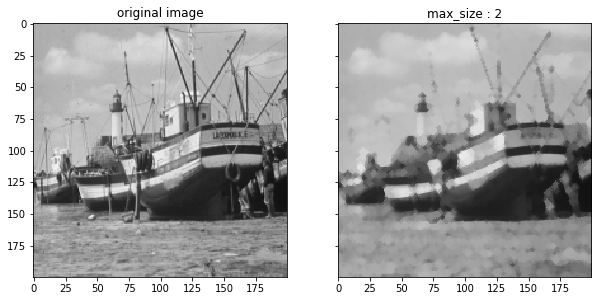

In [27]:
im= im_bat200
shape_d = "disk"
max_size = 2
axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 2, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

im_seq = sequential_f_reco(im,shape_d,max_size)
axs[1].imshow(im_seq,cmap="gray",vmin=0, vmax=255)
axs[1].set_title('max_size : '+ str(max_size))
plt.savefig("images/asf_reco_"+shape_d+str(size))

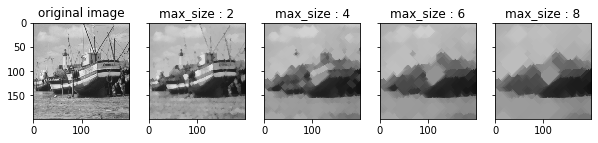

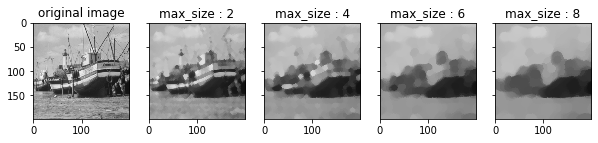

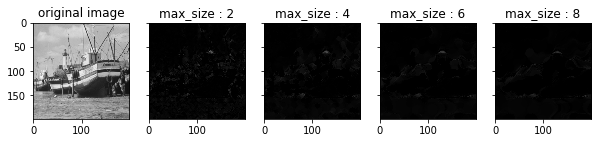

In [40]:
im= im_bat200
shape_d = "diamond"
max_sizes = [2,4,6,8]
axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 5, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
i = 0
for max_size in max_sizes:
    i += 1
    im_seq = sequential_f_reco(im,shape_d,max_size)
    axs[i].imshow(im_seq,cmap="gray",vmin=0, vmax=255)
    axs[i].set_title('max_size : '+ str(max_size))
#plt.savefig("images/asf_reco_"+shape_d, bbox_inches = 'tight')


im= im_bat200
shape_d = "disk"
max_sizes = [2,4,6,8]
axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 5, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
i = 0
for max_size in max_sizes:
    i += 1
    im_seq = sequential_f(im,shape_d,max_size)
    axs[i].imshow(im_seq,cmap="gray",vmin=0, vmax=255)
    axs[i].set_title('max_size : '+ str(max_size))
#plt.savefig("images/asf_"+shape_d, bbox_inches = 'tight')

#plot 
im= im_bat200
shape_d = "disk"
max_sizes = [2,4,6,8]
axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 5, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')
i = 0
for max_size in max_sizes:
    i += 1
    im_seq_p = sequential_f_reco(im.copy(),shape_d,max_size)
    im_seq = sequential_f(im.copy(),shape_d,max_size)
    axs[i].imshow(im_seq_p-im_seq,cmap="gray",vmin=0, vmax=255)
    axs[i].set_title('max_size : '+ str(max_size))
plt.savefig("images/asf_difference_"+shape_d, bbox_inches = 'tight')





## 4 - Segmentation

### Question 1&2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


ValueError: operands could not be broadcast together with shapes (253,255) (200,200) 

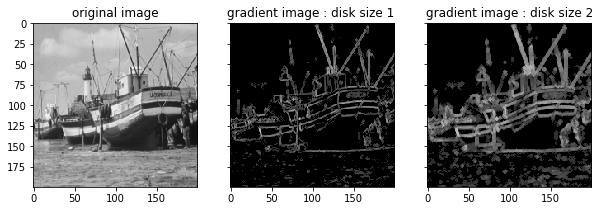

In [68]:
#%% Watersheds
im=im_bat200
se1=morpho.disk(1)
se2 = morpho.disk(2)

grad1=morpho.dilation(im,se1)-morpho.erosion(im,se1)
grad1=np.int32(grad1>40)*grad1

grad2=morpho.dilation(im,se2)-morpho.erosion(im,se2)
grad2=np.int32(grad2>40)*grad2

axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 3, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

axs[1].imshow(grad1,cmap="gray",vmin=0, vmax=255)
axs[1].set_title('gradient image : disk size 1 ')

axs[2].imshow(grad2,cmap="gray",vmin=0, vmax=255)
axs[2].set_title('gradient image : disk size 2')
#plt.savefig("images/grad_bat.png", bbox_inches='tight' )

local_mini = skf.peak_local_max(255-grad, #il n'y a pas de fonction local_min...
                            indices=False)
markers = ndi.label(local_mini)[0]

#plt.imshow(local_mini,cmap="gray")

labels = watershed(grad, markers,watershed_line=True)
#plt.imshow(couleurs_alea(labels))
#viewimage_color(couleurs_alea(labels)) - Utilisable si gimp est installé

# visualization of the result
segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
#superimposition of segmentation contours on the original image
contourSup=np.maximum(segm,im)
#plt.imshow(contourSup,cmap="gray") 
#plt.imshow(segm, cmap='gray')

axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1, 2, sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

axs[1].imshow(contourSup,cmap="gray",vmin=0, vmax=255)
axs[1].set_title("resultat de la segmentation")

#plt.savefig("watershed_bat", bbox_inches ='tight')
plt.show()
#%% FIN  exemples TP MORPHO

### Question 3

In [134]:
before = True
after = True

#%% Watersheds
im=im_bat200
im1=im_bat200

se1=morpho.disk(1)

if before :
    im1 = morpho.opening(im, strel("disk", 4))
    im1 = morpho.reconstruction(im1, im)
    #plt.imshow(im1, cmap="gray")
    #plt.show()


grad=morpho.dilation(im,se1)-morpho.erosion(im,se1)
grad=np.int32(grad>40)*grad

grad1=morpho.dilation(im1,se1)-morpho.erosion(im1,se1)
grad1=np.int32(grad1>40)*grad1

if after :
    grad1 = morpho.closing(grad1, strel('disk', 1))
    

#plt.savefig("images/grad_bat.png", bbox_inches='tight' )
local_mini = skf.peak_local_max(255-grad, indices=False) #il n'y a pas de fonction local_min...
markers = ndi.label(local_mini)[0]
labels = watershed(grad, markers,watershed_line=True)

local_mini1 = skf.peak_local_max(255-grad1, indices=False) #il n'y a pas de fonction local_min...
markers1 = ndi.label(local_mini1)[0]
labels1 = watershed(grad1, markers1,watershed_line=True)



#plt.imshow(couleurs_alea(labels))
#viewimage_color(couleurs_alea(labels)) - Utilisable si gimp est installé

# visualization of the result
segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
#superimposition of segmentation contours on the original image
contourSup=np.maximum(segm,im)


# visualization of the result
segm1=labels1.copy()
for i in range(segm1.shape[0]):
    for j in range(segm1.shape[1]):
        if segm1[i,j] == 0: 
            segm1[i,j]=255
        else:
            segm1[i,j]=0
#superimposition of segmentation contours on the original image
contourSup1=np.maximum(segm1,im1)




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


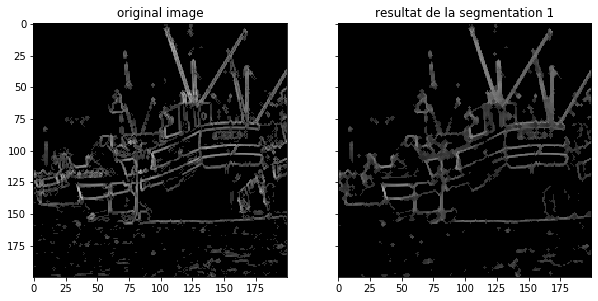

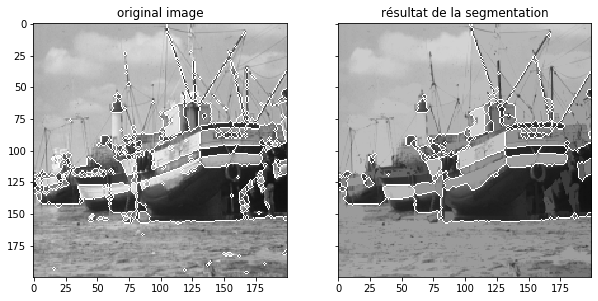

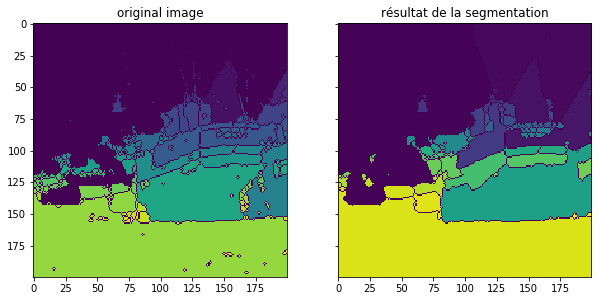

In [138]:
axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1,2 , sharex=True, sharey=True))
axs[0].imshow(grad,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

axs[1].imshow(grad1,cmap="gray",vmin=0, vmax=255)
axs[1].set_title("resultat de la segmentation 1")

plt.subplots_adjust(bottom=0.5)

#plt.savefig("watershed_close_after", bbox_inches ='tight')
plt.show()


axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1,2 , sharex=True, sharey=True))
axs[0].imshow(contourSup,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('original image')

axs[1].imshow(contourSup1,cmap="gray",vmin=0, vmax=255)
axs[1].set_title("résultat de la segmentation")

plt.subplots_adjust(bottom=0.5)

#plt.savefig("images/watershed_preprocessed", bbox_inches ='tight')
plt.show()

axs = (plt.figure(figsize=(10,15),constrained_layout=False)
       .subplots(1,2 , sharex=True, sharey=True))
axs[0].imshow(labels)
axs[0].set_title('original image')

axs[1].imshow(labels1)
axs[1].set_title("résultat de la segmentation")


plt.subplots_adjust(bottom=0.5)

#plt.savefig("images/watershed_preprocessed", bbox_inches ='tight')
plt.show()

### Question 4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  from ipykernel import kernelapp as app


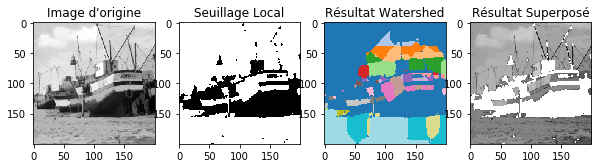

In [197]:
im=im_bat200

im1 = morpho.opening(im, strel("disk", 4))
im = morpho.reconstruction(im1, im)
# Appliquer un filtre de seuillage local (ici, nous utilisons un filtre de seuillage de Bernsen)
local_threshold = filters.threshold_local(im, block_size=351, offset=10)

# Créer une image binaire en fonction du seuil local
binary_image = im > local_threshold

binary_image = morpho.closing(binary_image, strel('disk', 1))

# Trouver les marqueurs pour l'algorithme Watershed
distance = ndi.distance_transform_edt(binary_image)
local_maxi = skf.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary_image)
markers = ndi.label(local_maxi)[0]

# Appliquer l'algorithme Watershed
labels = watershed(-distance, markers, mask=binary_image)

# visualization of the result
segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
#superimposition of segmentation contours on the original image
contourSup=np.maximum(segm,im)


# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.subplot(141), plt.imshow(im, cmap='gray'), plt.title('Image d\'origine')
plt.subplot(142), plt.imshow(binary_image, cmap='gray'), plt.title('Seuillage Local')
plt.subplot(143), plt.imshow(labels, cmap='tab20'), plt.title('Résultat Watershed')
plt.subplot(144), plt.imshow(contourSup, cmap='gray'), plt.title('Résultat Superposé')

#plt.savefig("watershed_local_threshold", bbox_inches = 'tight')

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


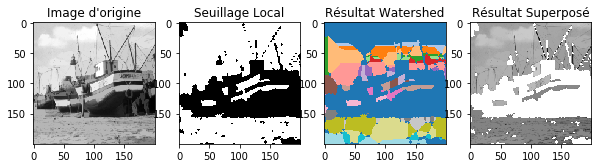

In [198]:
im=im_bat200

im1 = morpho.opening(im, strel("disk", 4))
im = morpho.reconstruction(im1, im)

# Appliquer un filtre de seuillage de Niblack
window_size = 251  # Taille de la fenêtre pour le seuillage
k = -0.2  # Paramètre k pour le seuillage de Niblack
local_threshold = filters.threshold_niblack(im, window_size=window_size, k=k)

# Créer une image binaire en fonction du seuil local
binary_image = im > local_threshold

binary_image = morpho.closing(binary_image, strel('disk', 1))


# Trouver les marqueurs pour l'algorithme Watershed
distance = ndi.distance_transform_edt(binary_image)
local_maxi = skf.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary_image)
markers = ndi.label(local_maxi)[0]

# Appliquer l'algorithme Watershed
labels = watershed(-distance, markers, mask=binary_image)
# visualization of the result
segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
#superimposition of segmentation contours on the original image
contourSup=np.maximum(segm,im)


# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.subplot(141), plt.imshow(im, cmap='gray'), plt.title('Image d\'origine')
plt.subplot(142), plt.imshow(binary_image, cmap='gray'), plt.title('Seuillage Local')
plt.subplot(143), plt.imshow(labels, cmap='tab20'), plt.title('Résultat Watershed')
plt.subplot(144), plt.imshow(contourSup, cmap='gray'), plt.title('Résultat Superposé')

plt.savefig("watershed_niblack_threshold", bbox_inches = 'tight')


plt.show()

### Question 5

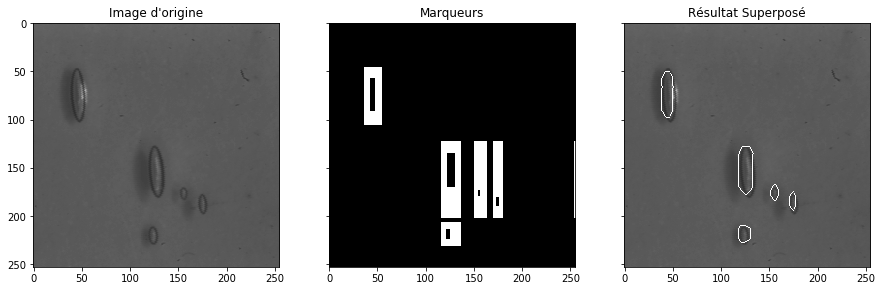

In [65]:
im = im_bulles
if len(im.shape)>2 and im.shape[2] == 3:
    im=grayscale_from_color(im)
    
#plt.imshow(im, cmap="gray", vmin=0, vmax=255)
#plt.show()

#Define markers
inside_markers = np.zeros_like(im)
inside_markers += 255
inside_markers[58:92,42:47] = 0  
inside_markers[135:170,122:130] = 0  
inside_markers[173:180, 154:156] = 0 
inside_markers[181:190,172:176] = 0  
inside_markers[214:224,121:125] = 0  

outside_markers = np.zeros_like(im)
outside_markers += 255
outside_markers[0:255,0:36] = 0
outside_markers[0:255,55:116] = 0
outside_markers[0:255,136:150] = 0
outside_markers[0:255,163:169] = 0
outside_markers[0:255,180:253] = 0
outside_markers[0:46,0:255] = 0
outside_markers[106:255, 0:116] = 0
outside_markers[202:255,136:255] = 0
outside_markers[46:123, 55:255] = 0
outside_markers[106:123, 0:255] = 0
outside_markers[202:207, 0:255] = 0
outside_markers[231:255, 0:255] = 0


# Combine the markers
markers = np.minimum(inside_markers,outside_markers)

# Compute gradient
grad = morpho.dilation(im, strel("disk",1)) - morpho.erosion(im, strel("disk",1))
grad = np.int32(grad > 5) * grad 


# Compute I' = I ∧ m 
I_p = np.minimum(grad, markers)

# Reconstruct I' by erosion from m
im_reconstructed = morpho.reconstruction(I_p, markers)

# Compute the watersheds of the reconstructed image
peak_mask = np.zeros_like(grad, dtype=bool)
peak_mask[markers==0] = True
new_markers, _ = measure.label(peak_mask, return_num = True)

labels = watershed(im_reconstructed, new_markers, watershed_line=True)

# Visualization of the result
segm = labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i, j] == 0:
            segm[i, j] = 255
        else:
            segm[i, j] = 0
# Superimposition of segmentation contours on the original image
contourSup = np.maximum(segm, im)


axs = (plt.figure(figsize=(15,20),constrained_layout=False)
       .subplots(1,3 , sharex=True, sharey=True))
axs[0].imshow(im,cmap="gray",vmin=0, vmax=255)
axs[0].set_title('Image d\'origine')

axs[1].imshow(markers,cmap="gray")
axs[1].set_title('Marqueurs')

axs[2].imshow(contourSup,cmap="gray",vmin=0, vmax=255)
axs[2].set_title("Résultat Superposé")


#plt.savefig("images/question5", bbox_inches = 'tight')

plt.show()